# <span> Laboratorio di Simulazione Numerica </span>
## <span>  Esercitazione 8 </span>

In questa esercitazione vogliamo determinare la funzione d'onda e l'energia dello stato fondamentale di una particella quantistica soggetta al seguente potenziale esterno

$$ V(x) = x^4 - \frac{5}{2}x^2 $$

Si tratta di un problema non risolvibile analiticamente, quindi è necessario un approccio numerico. Le unità di misura utilizzate sono quelle in cui $\hbar = 1$, $m = 1$ e $k_B=1$.

### Esercizi 8.1-8.2

In questi primi due esercizi si sfrutta il <b>principio variazionale</b> per dare una stima approssimata della funzione d'onda e dell'energia dello stato fondamentale. Consideriamo la seguente funzione di prova non normalizzata

$$\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}} $$

I parametri variazionali $\mu$ e $\sigma$ sono determinati minimizzando il valore di aspettazione dell'Hamiltoniana sulla funzione d'onda di prova, che è dato da

$$ E = \langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} =  \frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)} {\int dx |\Psi_T(x)|^2} =  \int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} $$

Per calcolare l'energia è necessario campionare il modulo quadro della funzione d'onda di prova: per fare questo si sfrutta l'algoritmo di <b>Metropolis</b>. Viene utilizzata una probabilità di transizione uniforme, estraendo una nuova posizione nel segmento di lunghezza $l$ centrato nella posizione attuale. Il parametro libero $l$ viene determinato in modo tale da fissare l'accettazione al $50 \%$. Ricordiamo che, prima di iniziare le misure delle quantità di interesse, l'algoritmo di Metropolis necessita di una fase di equilibrazione: $300$ step sono sufficienti per equilibrare l'algoritmo se si parte dalla posizione iniziale $x = 10\mu$ per tutti i valori di $\mu$ e $\sigma$ considerati; in alternativa, possiamo evitare la fase di equilibrazione iniziando la simulazione da una posizione $x$ tale che $|x| \sim \mu$. 

La struttura del codice è identica a quella utilizzata nella esercitazione 5. Viene modificata la classe Metropolis sostituendo il vettore posizione con una variabile di tipo double, in quanto stiamo considerando un problema unidimensionale. Viene modificata anche la classe FunzioneBase in modo tale da aggiungere la nuova densità di probabilità.

Per prima cosa determiano i parametri variazionali. Facendo variare $\mu$ nell'intervallo $[0.76,0.83]$ e $\sigma$ nell'intervallo $[0.58,0.65]$ con passi di $0.001$, per ogni coppia di valori vengono effettuati $10^5$ step dell'algoritmo di Metropolis per ottenere la stima dell'energia. Di seguito viene riportato uno scatter bidimensionale in cui ogni punto corrisponde a una particolare coppia $(\mu, \sigma)$ e presenta un colore in base al valore dell'energia.

In [1]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

In [2]:
mu, sigma, ene = np.loadtxt("8.1/var.dat", usecols=(0,1,2), delimiter=' ', unpack='true')

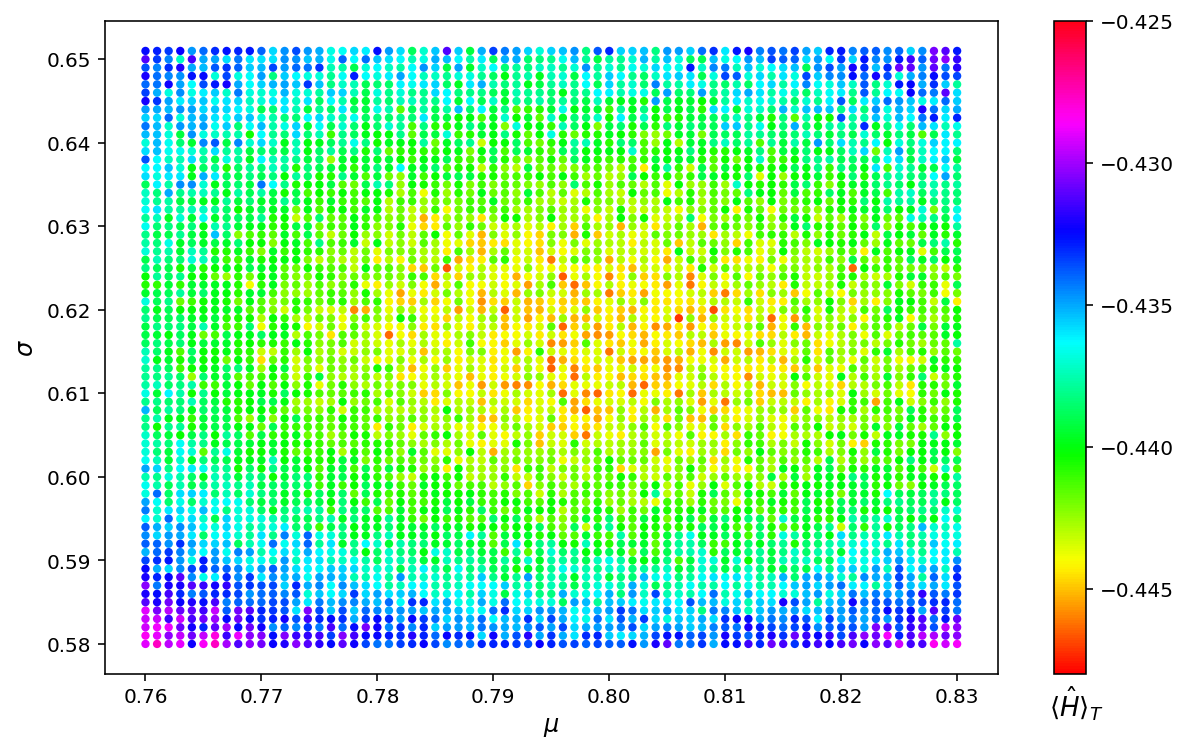

In [3]:
fig = plt.figure(figsize=(10, 6))
cm = plt.cm.get_cmap('hsv')
sc = plt.scatter(mu, sigma, c=ene, vmin=-0.448, vmax=-0.425, s=10, cmap=cm)
plt.xlabel(r'$\mu$', fontsize=12)
plt.ylabel(r'$\sigma$', fontsize=12)
clb = plt.colorbar(sc, orientation='vertical')
clb.set_label(r'$\langle {\hat H} \rangle_T$', labelpad=-49, y=-0.015, rotation=0, fontsize=13)
plt.show()

I valori che minimizzano $\langle {\hat H} \rangle_T$ sono

- <span> $\mu = 0.806$ </span>
- <span> $\sigma = 0.619$ </span>

A questo punto regoliamo l'accettazione del Metropolis, arrivando al valore di $l = 5.3$. Ora che lo stato della particella è stato determinato, viene calcolata la stima dell'energia con la relativa incertezza statistica tramite il metodo del data blocking: vengono utilizzati $100$ blocchi da $5000$ step ciascuno. Di seguito viene riportato l'andamento dell'energia all'aumentare del numero di blocchi. <br>
Riportiamo anche un istogramma della densità di probabilità campionata: per farlo ad ogni step viene salvata la posizione della particella nel file <i>position.out</i>; le posizioni vengono poi divise in $100$ bin nel seguente script di python. La funzione d'onda ottenuta è stata confrontata con la forma analitica determinata numericamente trasformando l'equazione di Schrodinger in una equazione matriciale e diagonalizzandola, trovando così autovalori e autofunzioni dell'Hamiltoniana.

In [4]:
block, energy, err_energy = np.loadtxt("8.1/energy.out", usecols=(0,1,2), delimiter=' ', unpack='true')
pos = np.loadtxt("8.1/position.out")

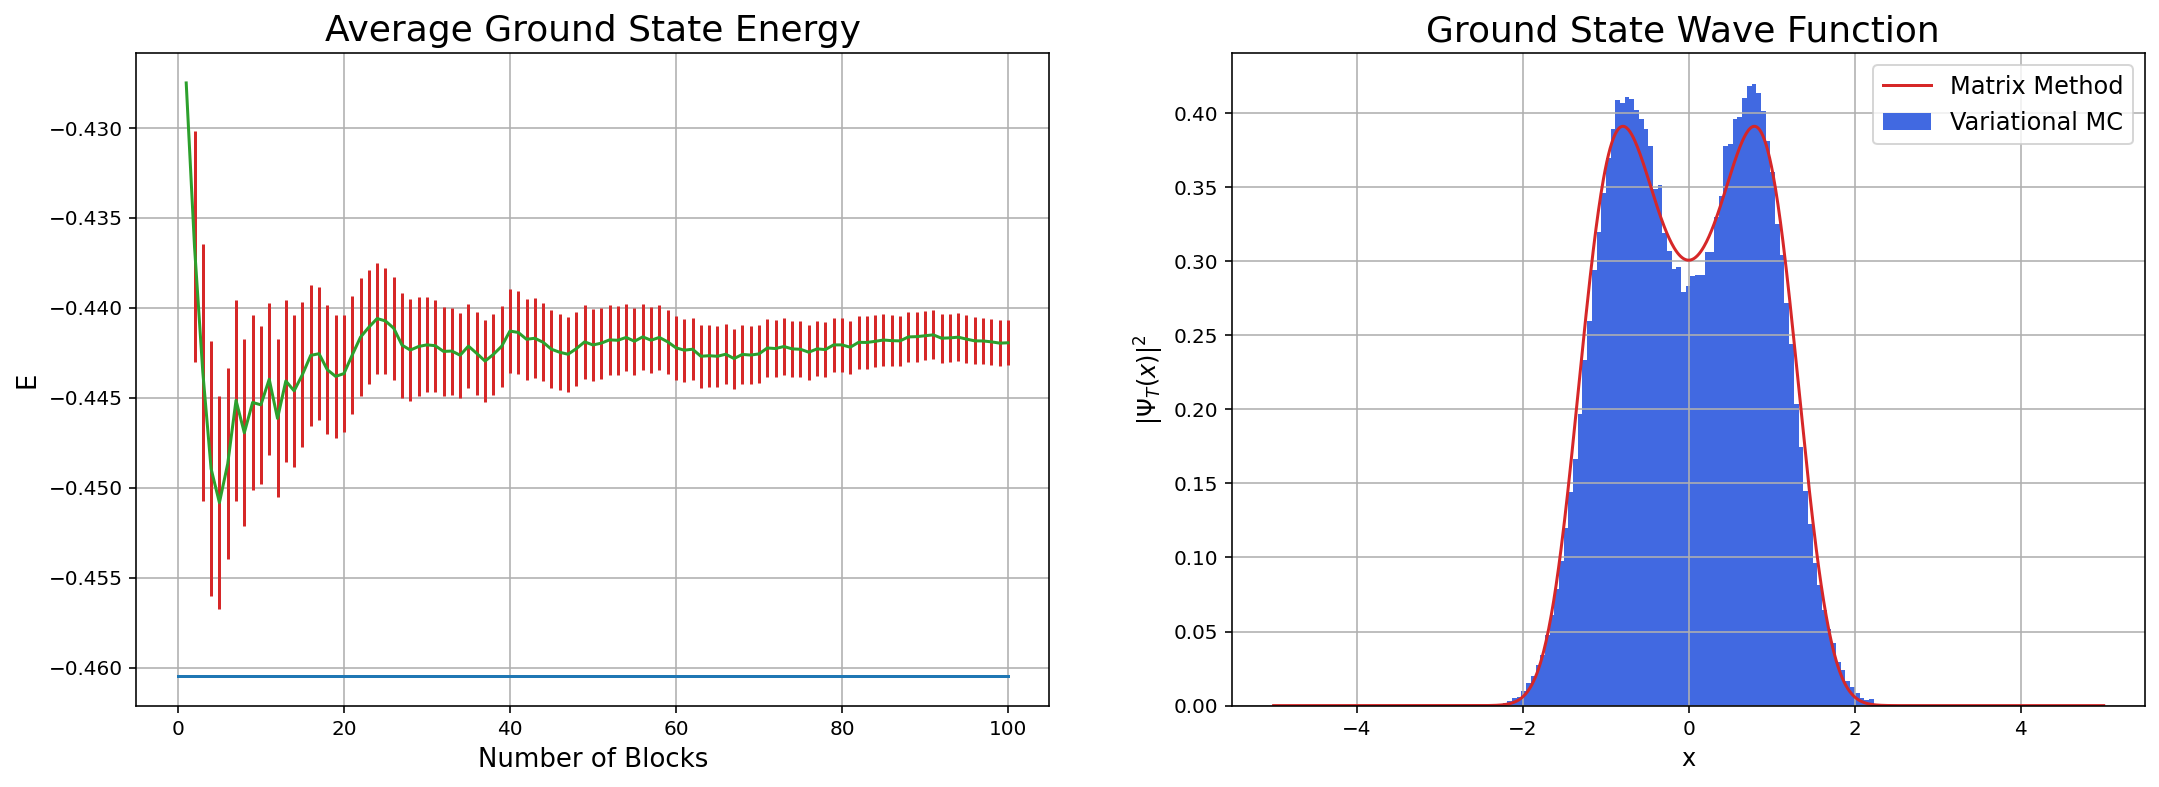

        ######### Ground State Energy ########
        ##### Variational MC:  -0.441943 #####
        ###### Matrix Method:  -0.460466 #####
        ######################################


In [5]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

fig, ax = plt.subplots(1, 2, figsize=(18,6))

ax[0].errorbar(block, energy, yerr = err_energy, c='tab:green', ecolor='tab:red')
ax[0].plot([0,100], [E[0],E[0]], c='tab:blue')
ax[0].set_xlabel('Number of Blocks', fontsize=13)
ax[0].set_ylabel('E', fontsize=13)
ax[0].set_title('Average Ground State Energy', fontsize=18)
ax[0].grid(True)

ax[1].hist(pos, bins=100, density="True", label='Variational MC', color='royalblue')
ax[1].plot(x,(psi[0])**2, label='Matrix Method', c='tab:red')
ax[1].set_xlabel('x', fontsize=12)
ax[1].set_ylabel('$|\Psi_T(x)|^2$', fontsize=12)
ax[1].set_title('Ground State Wave Function ', fontsize=18)
ax[1].legend(loc='best', fontsize=12)
ax[1].grid(True)
plt.show()

print('        ######### \033[4mGround State Energy\033[0m ########')
print('        ##### Variational MC: \033[1m', energy[-1], '\033[0m#####')
print('        ###### Matrix Method: \033[1m', "{:.6f}".format(E[0]), '\033[0m#####')
print('        ######################################')

Come ci si poteva aspettare, la media di blocco converge ad un'energia maggiore rispetto al valore calcolato con il metodo delle matrici; infatti, la funzione di prova considerata è soltanto un'approssimazione dello stato fondamentale, pertanto sarà una sovrapposizione degli autostati dell'energia: di conseguenza l'energia sarà necessariamente maggiore di quella di ground state. In ogni caso, sebbene siamo partiti da un modello molto semplici con solamente due parametri, si ottiene una buona somiglianza con la funzione d'onda calcolata dall'equazione di Schrodinger: si nota soltanto una discrepanza nella regione centrale, in corrispondenza dei massimmi e del minimo locale della funzione.

### Esercizio 8.3

In questo esercizio studiamo lo stesso sistema quantistico tramite i codici <b>PIGS</b> (Path Integral Ground State) e <b>PIMC</b> (Path Integral Monte Carlo) che ci sono stati forniti in laboratorio. <br>
PIGS è un metodo che permette di campionare il ground state di una Hamiltoniana tramite l'evoluzione per tempi immaginari di una funzione d'onda di prova. Sono state utilizzate due diverse funzioni d'onda di prova: una funzione costante $\Psi_T = 1$ e la funzione ottenuta dagli esercizi precedenti tramite il principio variazionale. <br>
PIMC è un metodo che permette di campionare la funzione d'onda e calcolare valori di aspettazione di osservabili fisiche di un sistema quantistico che si trova a una certa temperatura, sfruttando l'insieme canonico.

Prima di iniziare la simulazione è stato necessario modificare la parte del codice in cui vengono definiti il potenziale esterno e la funzione d'onda di partenza.

### PIGS

Per entrambe le funzioni d'onda di prova considerate riportiamo il modulo quadro della funzione d'onda finale per i seguenti valori del tempo di propagazione: $\tau = 8,5,1,0.5,0.2$. 

In [6]:
r, prob_var_8, err_prob_var_8 = np.loadtxt("QMC_1D/PIGS/Var_8/probability.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
prob_var_5, err_prob_var_5 = np.loadtxt("QMC_1D/PIGS/Var_5/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_var_1, err_prob_var_1 = np.loadtxt("QMC_1D/PIGS/Var_1/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_var_05, err_prob_var_05 = np.loadtxt("QMC_1D/PIGS/Var_05/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_var_02, err_prob_var_02 = np.loadtxt("QMC_1D/PIGS/Var_02/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')

prob_const_8, err_prob_const_8 = np.loadtxt("QMC_1D/PIGS/Const_8/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_const_5, err_prob_const_5 = np.loadtxt("QMC_1D/PIGS/Const_5/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_const_1, err_prob_const_1 = np.loadtxt("QMC_1D/PIGS/Const_1/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_const_05, err_prob_const_05 = np.loadtxt("QMC_1D/PIGS/Const_05/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_const_02, err_prob_const_02 = np.loadtxt("QMC_1D/PIGS/Const_02/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')

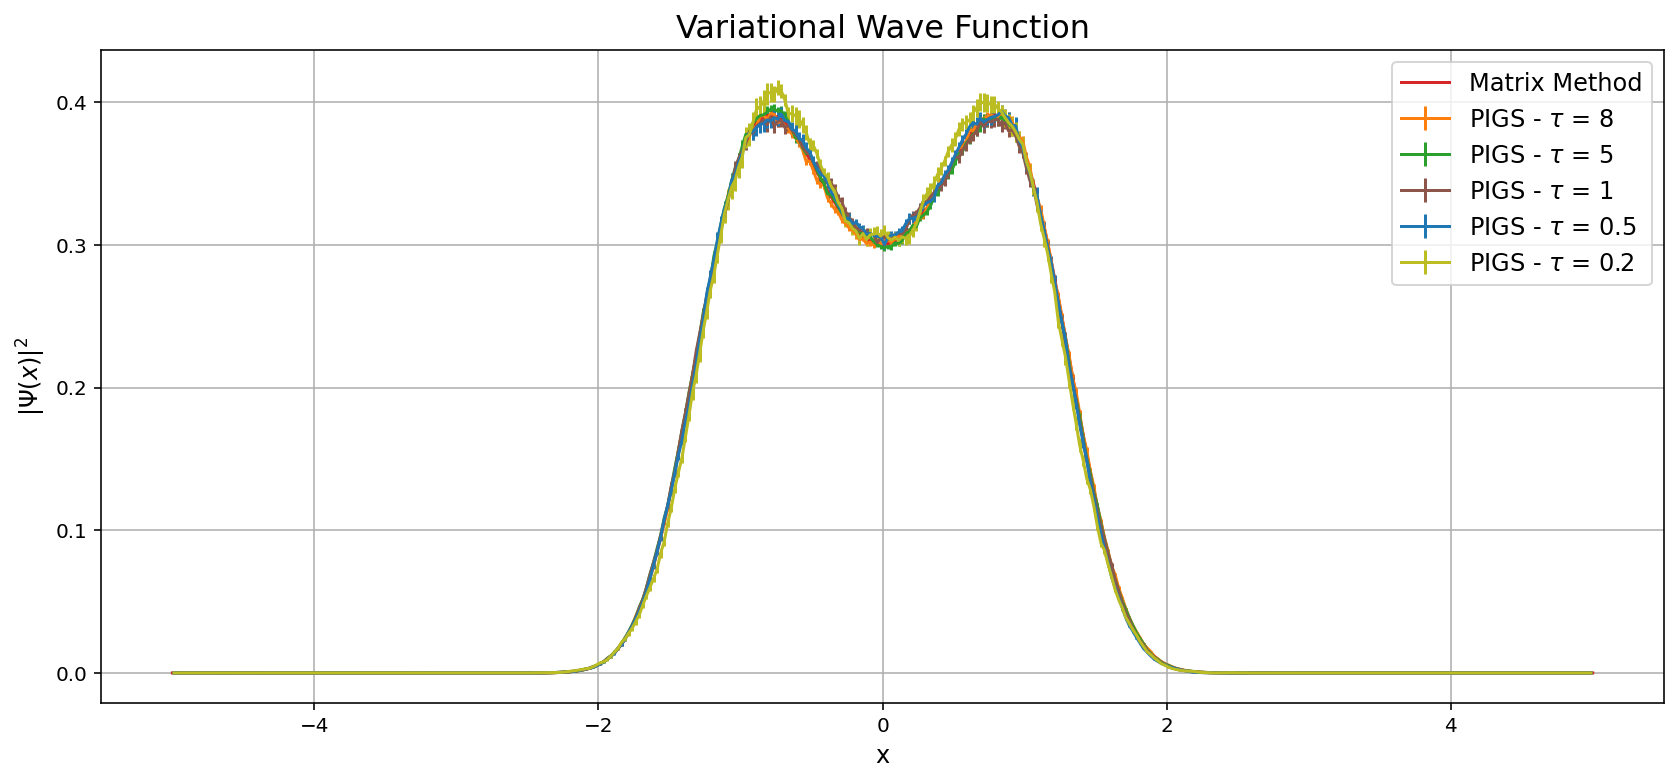

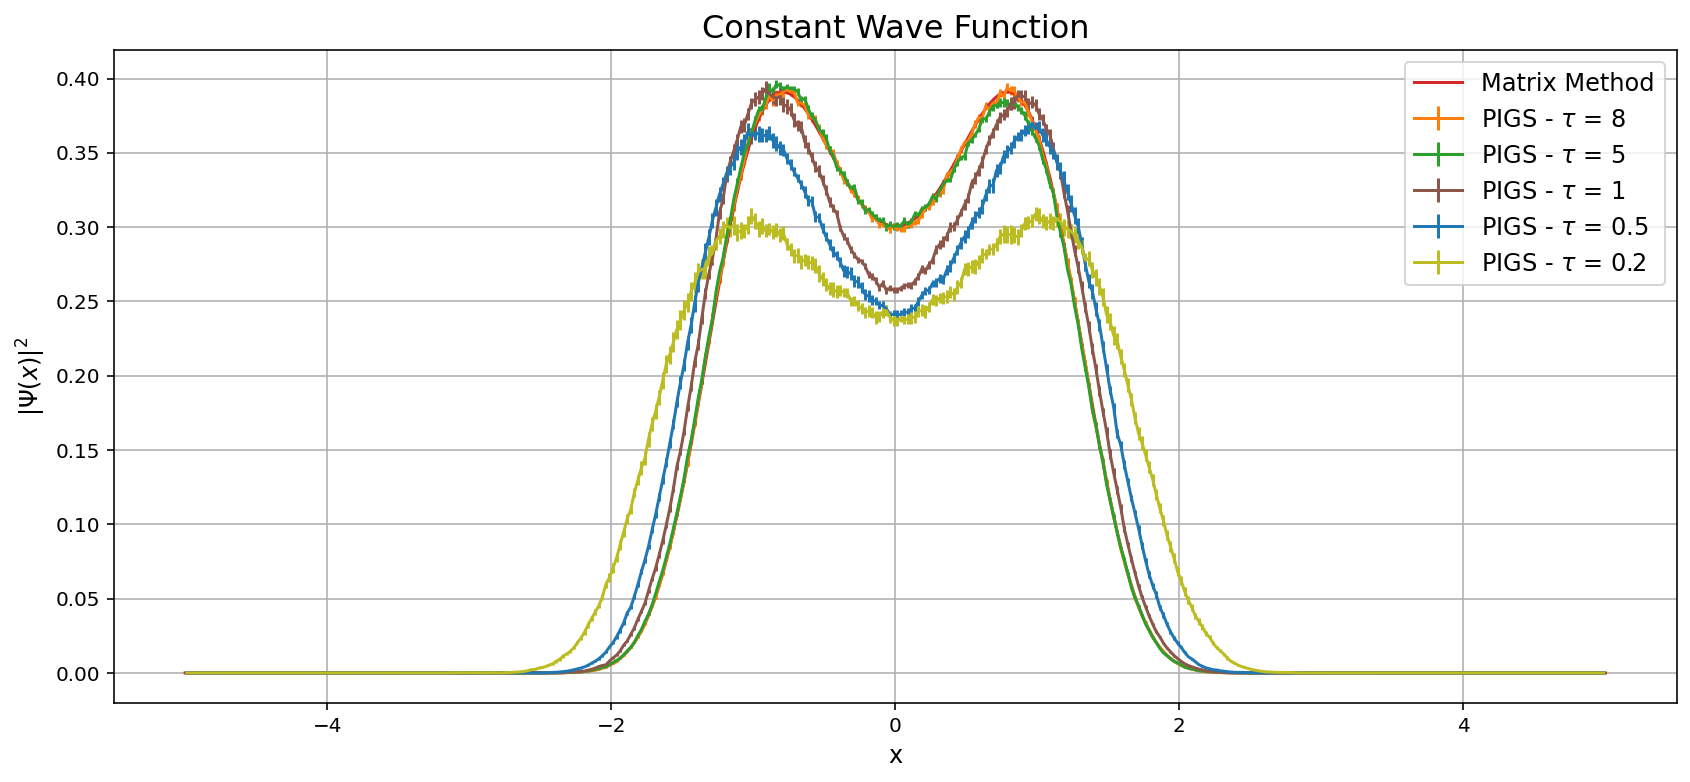

In [7]:
fig=plt.figure(figsize=(14,6))

plt.errorbar(r, prob_var_8, yerr= err_prob_var_8, label=r'PIGS - $\tau$ = 8', c='tab:orange')
plt.errorbar(r, prob_var_5, yerr= err_prob_var_5, label=r'PIGS - $\tau$ = 5', c='tab:green')
plt.errorbar(r, prob_var_1, yerr= err_prob_var_1, label=r'PIGS - $\tau$ = 1', c='tab:brown')
plt.errorbar(r, prob_var_05, yerr= err_prob_var_05, label=r'PIGS - $\tau$ = 0.5', c='tab:blue')
plt.errorbar(r, prob_var_02, yerr= err_prob_var_02, label=r'PIGS - $\tau$ = 0.2', c='tab:olive')
plt.plot(x,(psi[0])**2, label='Matrix Method', c='tab:red')
plt.xlabel(r'x', fontsize=12)
plt.ylabel('$|\Psi(x)|^2$', fontsize=12)
plt.title(f'Variational Wave Function', fontsize=16)
plt.grid(True)
plt.legend(loc='best', fontsize=12)

fig=plt.figure(figsize=(14,6))

plt.errorbar(r, prob_const_8, yerr= err_prob_const_8, label=r'PIGS - $\tau$ = 8', c='tab:orange')
plt.errorbar(r, prob_const_5, yerr= err_prob_const_5, label=r'PIGS - $\tau$ = 5', c='tab:green')
plt.errorbar(r, prob_const_1, yerr= err_prob_const_1, label=r'PIGS - $\tau$ = 1', c='tab:brown')
plt.errorbar(r, prob_const_05, yerr= err_prob_const_05, label=r'PIGS - $\tau$ = 0.5', c='tab:blue')
plt.errorbar(r, prob_const_02, yerr= err_prob_const_02, label=r'PIGS - $\tau$ = 0.2', c='tab:olive')
plt.plot(x,(psi[0])**2, label='Matrix Method', c='tab:red')
plt.xlabel(r'x', fontsize=12)
plt.ylabel('$|\Psi(x)|^2$', fontsize=12)
plt.title(f'Constant Wave Function', fontsize=16)
plt.grid(True)
plt.legend(loc='best', fontsize=12)

plt.show()

Per $\tau = 8$ e $\tau = 5$ si ottiene, in entrambi i casi, una funzione d'onda finale in accordo con quella ottenuta tramite il metodo delle matrici. <br>
Nel caso della funzione costante, al diminuire di $\tau$ la funzione d'onda finale si discosta in maniera significativa da quella di ground state, assumendo sempre più una forma larga e piatta, simile alla funzione di partenza. Questo non avviene quando parto da una funzione d'onda già simile a quello dello stato fondamentale, come nel caso della funzione d'onda variazionale, in cui solamente per $\tau =0.2$ il risultato si inizia a discostare dal ground state. Riusciamo quindi a ridurre di un fattore $10$ il tempo di propagazione immaginario scegliendo opportunamente la funzione d'onda di prova.

Nel caso in cui $\tau = 8$ riportiamo per entrambe le funzioni di prova l'andamento dell'energia potenziale e dell'energia cinetica in funzione del numero di timeslices, ovvero degli atomi del polimero sul quale viene mappato questo problema.

In [8]:
step, pot_var_1, err_pot_var_1 = np.loadtxt("QMC_1D/PIGS/Var_1/potential.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
kin_var_1, err_kin_var_1 = np.loadtxt("QMC_1D/PIGS/Var_1/kinetic.dat", usecols=(1,2), delimiter=' ', unpack='true')
pot_var_8, err_pot_var_8 = np.loadtxt("QMC_1D/PIGS/Var_8/potential.dat", usecols=(1,2), delimiter=' ', unpack='true')
kin_var_8, err_kin_var_8 = np.loadtxt("QMC_1D/PIGS/Var_8/kinetic.dat", usecols=(1,2), delimiter=' ', unpack='true')

pot_const_1, err_pot_const_1 = np.loadtxt("QMC_1D/PIGS/Const_1/potential.dat", usecols=(1,2), delimiter=' ', unpack='true')
kin_const_1, err_kin_const_1 = np.loadtxt("QMC_1D/PIGS/Const_1/kinetic.dat", usecols=(1,2), delimiter=' ', unpack='true')
pot_const_8, err_pot_const_8 = np.loadtxt("QMC_1D/PIGS/Const_8/potential.dat", usecols=(1,2), delimiter=' ', unpack='true')
kin_const_8, err_kin_const_8 = np.loadtxt("QMC_1D/PIGS/Const_8/kinetic.dat", usecols=(1,2), delimiter=' ', unpack='true')

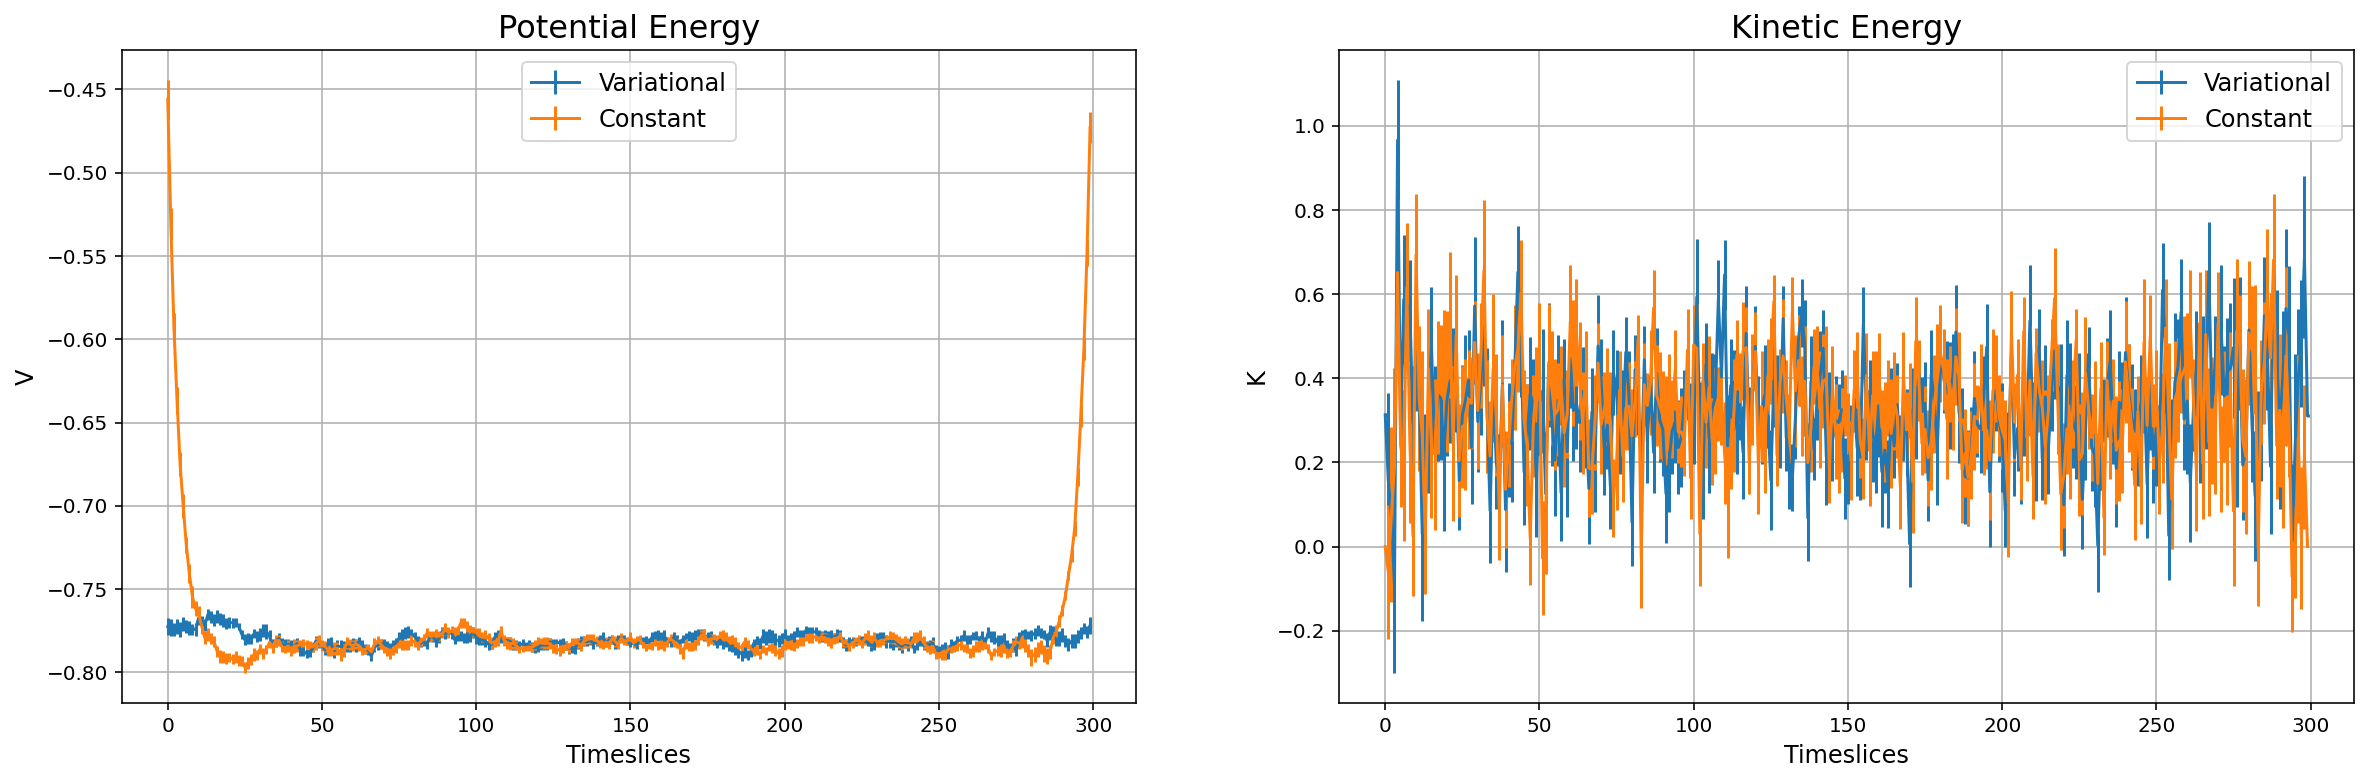

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.reshape(-1)

ax[0].errorbar(step, pot_var_8, yerr= err_pot_var_8, color="tab:blue", label='Variational')
ax[0].errorbar(step, pot_const_8, yerr= err_pot_const_8, color="tab:orange", label='Constant')
ax[1].errorbar(step, kin_var_8, yerr= err_kin_var_8, color="tab:blue", label='Variational')
ax[1].errorbar(step, kin_const_8, yerr= err_kin_const_8, color="tab:orange", label='Constant')
ax[0].set_xlabel(r'Timeslices', fontsize=12)
ax[0].set_ylabel('V', fontsize=12)
ax[0].set_title(r'Potential Energy', fontsize=16)
ax[0].grid(True)
ax[0].legend(loc='best', fontsize=12)
ax[1].set_xlabel(r'Timeslices', fontsize=12)
ax[1].set_ylabel('K', fontsize=12)
ax[1].set_title(r'Kinetic Energy', fontsize=16)
ax[1].grid(True)
ax[1].legend(loc='best', fontsize=12)

plt.show()

Nei due valori limite di timeslices il bra e il ket non sono stati propagati e coincidono con lo stato di partenza;  questo implica che nel caso in cui la funzione d'onda di prova sia la funzione costante l'energia potenziale abbia un valore maggiore rispetto a quello che si ottiene misurando l'energia potenziale per valori centrali delle timeslices, dove sia il bra che il ket sono stati sufficientemente propagati. Questo trend dell'energia potenziale non si osserva nel caso in cui la funzione d'onda di prova sia quella ottenuta dal metodo variazionale dato che questa ha già una forma molto simile a quella del ground state e il potenziale di fatto assume lo stesso valore sia che quando valutato ai limiti della catena che nelle zone più centrali. <br>
L'andamento dell'energia cinetica è molto fluttuante in entrambi i casi.

### PIMC

Utilizziamo il codice PIMC per vedere come cambia la funzione d'onda del sistema aumentando la temperatura. Viene eseguita la simulazione per 4 valori diversi della temperatura: $T=1, 5, 10 ,50$. Di seguito viene riportato per ogni valore della temperatura il modulo quadro della funzione d'onda del sistema.

In [10]:
r, prob_1, err_prob_1 = np.loadtxt("QMC_1D/PIMC/1/probability.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
prob_5, err_prob_5 = np.loadtxt("QMC_1D/PIMC/5/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_10, err_prob_10 = np.loadtxt("QMC_1D/PIMC/10/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')
prob_50, err_prob_50 = np.loadtxt("QMC_1D/PIMC/50/probability.dat", usecols=(1,2), delimiter=' ', unpack='true')

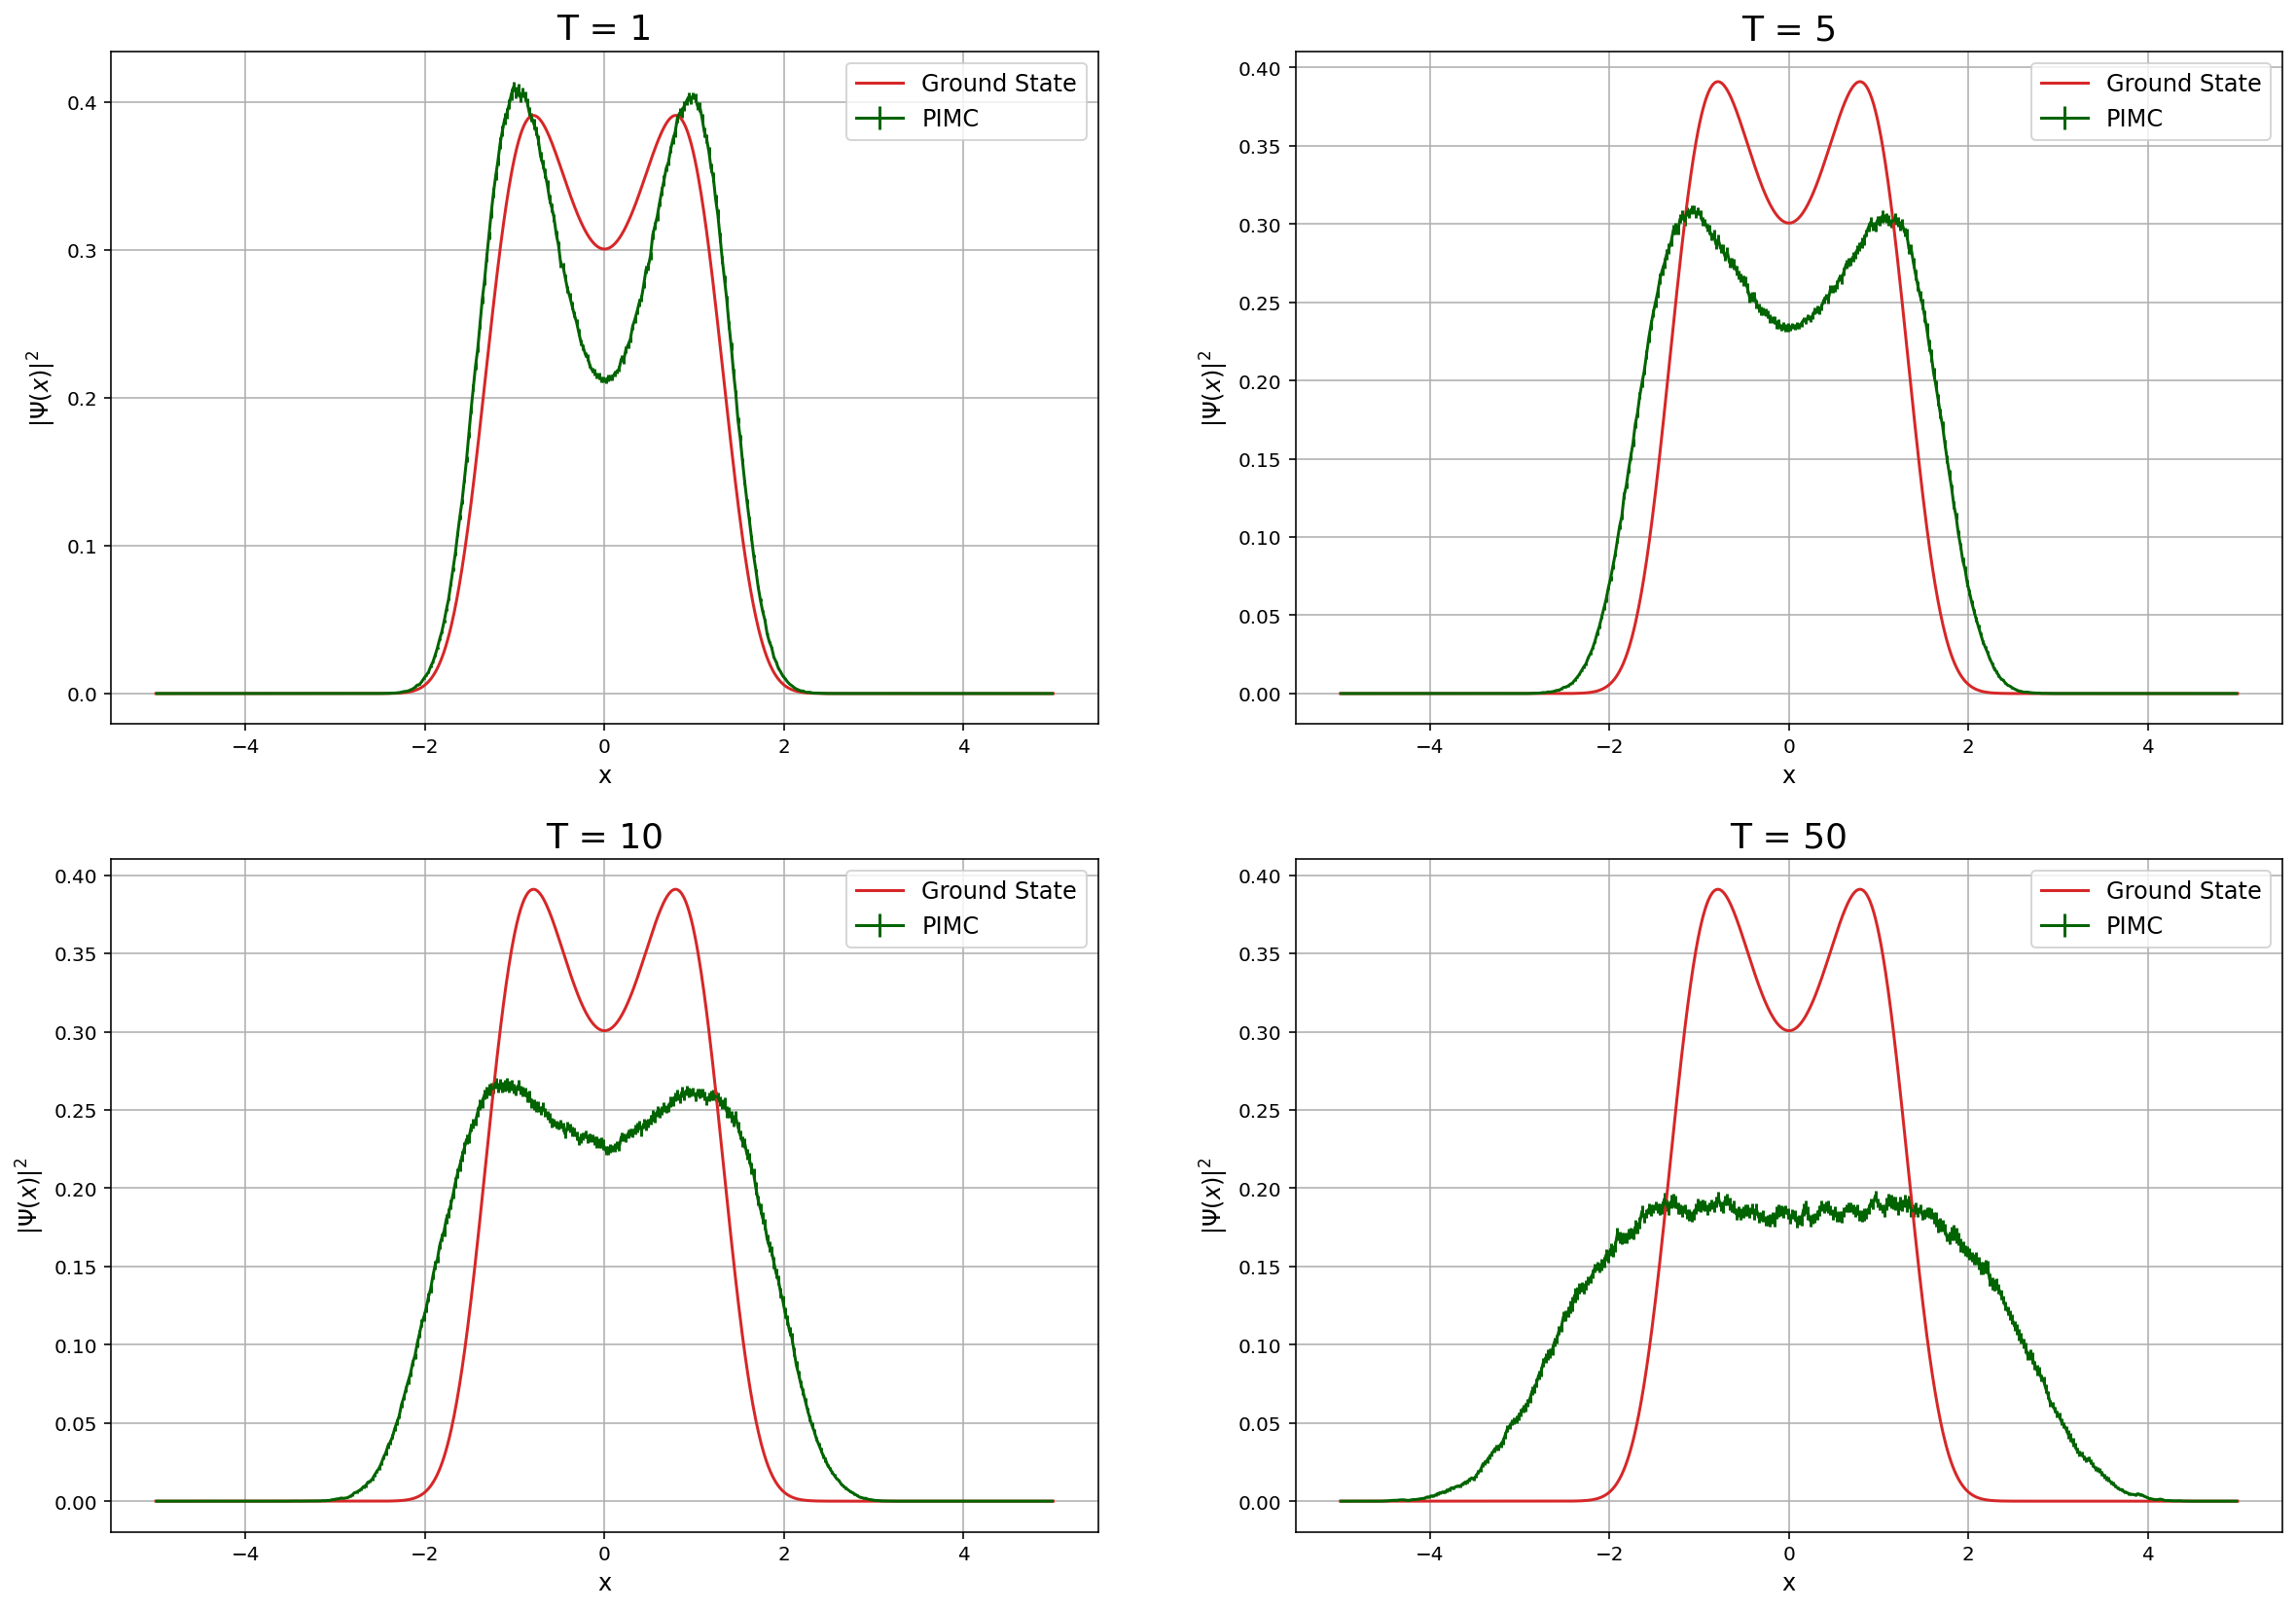

In [11]:
prob_list = [prob_1, prob_5, prob_10, prob_50]
err_prob_list = [err_prob_1, err_prob_5, err_prob_10, err_prob_50]
T_list = ['1', '5', '10', '50']

# plot
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
ax = ax.reshape(-1)

for i in range(4):
    ax[i].errorbar(r, prob_list[i], yerr= err_prob_list[i], color="darkgreen", label='PIMC')
    ax[i].plot(x,(psi[0])**2, label='Ground State', color='tab:red')
    ax[i].set_xlabel(r'x', fontsize=12)
    ax[i].set_ylabel('$|\Psi(x)|^2$', fontsize=12)
    ax[i].set_title(f'T = {T_list[i]}', fontsize=18)
    ax[i].grid(True)
    ax[i].legend(loc='best', fontsize=12)

plt.show()

A temperatura finita la funzione d'onda del sistema si discosta da quella dello stato fondamentale in quanto iniziano ad essere occupati stati ad energia maggiore, che sarebbero inaccessibili a temperatura nulla. Si noti la particolare forma della funzione d'onda nel caso in cui $T=1$: a tale temperatura di fatto sono occupati lo stato fondamentale e il primo stato eccitato e proprio la forma della funzione d'onda di quest'ultimo provoca l'abbassamento del minimo locale in $x=0$. Man mano che la temperatura aumenta si può notare come la funzione d'onda assuma sempre più la forma di un'onda piana nella regione classicamente permessa, decadendo esponenzialmente nella regione classicamente proibita.